In [47]:
!pip install ucimlrepo

In [48]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_classification

In [49]:
# Dataset

# fetch dataset
wine = fetch_ucirepo(id=109)

# data (as pandas dataframes)
X = wine.data.features
y = wine.data.targets

X = X.iloc[:130]
y = y.iloc[:130]

X=(X-X.mean())/X.std()

y = y - 1

In [50]:
y = y['class']

In [51]:
new_column_names = list(range(X.shape[1]))
X.rename(columns=dict(zip(X.columns, new_column_names)), inplace=True)
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.446858,-0.293280,0.301312,-0.936752,1.761871,0.508454,0.772603,-0.460466,0.996374,0.888945,-0.111994,2.032163,0.779851
1,0.287952,-0.213731,-0.674587,-2.230695,0.006501,0.233424,0.365970,-0.643806,-0.875481,0.113933,-0.052714,0.937809,0.737300
2,0.242946,0.445383,1.108952,-0.054518,0.071515,0.508454,1.016583,-0.277126,1.960101,0.913548,-0.171275,0.453768,1.120264
3,1.604379,-0.020543,0.536874,-0.583858,0.851679,2.433670,1.355445,-0.827146,0.792509,2.217536,-1.179042,1.043036,1.957113
4,0.332958,0.706756,1.781986,0.651270,1.176748,0.508454,0.271089,0.547905,0.125313,0.077028,-0.111994,-0.051318,-0.156284


In [52]:
def logistic_loss(X, y, weight):
    z = np.dot(X, weight)
    p = 1 / (1 + np.exp(-z))
    loss = -np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))
    return loss

In [53]:
def compute_loss(X, y, weight, idx, alpha, beta, l):

    w_0 = weight[idx]
    w_p = w_0 + alpha
    w_m = w_0 - alpha

    weight[idx] = w_p
    lp = logistic_loss(X, y, weight)
    weight[idx] = w_m
    lm = logistic_loss(X, y, weight)

    weight[idx] = w_0

    if lp < l:
        return alpha, lp
    elif lm < l:
        return -1*alpha, lm
    elif lp > l and lm > l:
        return compute_loss(X, y, weight, idx, alpha/beta, beta, l)         # prevent infinite condition, use convergence logic

In [54]:
def select_weight(X, y, w, alpha, beta, random_select=False):

    weight = []
    for i in range(len(w)):
        weight.append(w[i])
    l_all = logistic_loss(X, y, weight)

    if random_select:
        idx = random.randint(0, len(weight)-1)
        delta, loss = compute_loss(X, y, weight, idx, alpha, beta, l_all)
        dynamic_alpha = alpha
    else:
        idx = 0
        loss = float('inf')
        delta = alpha
        dynamic_alpha = 0
        for i in range(len(w)):
            d, l = compute_loss(X, y, weight, i, alpha, beta, l_all)
            if l < loss:
                loss = l
                idx = i
                delta = d
            if abs(d) > dynamic_alpha:
                dynamic_alpha = abs(d)
    return idx, delta, dynamic_alpha, loss

In [55]:
def update_all_weights(X, y, w, alpha, beta):

    weight = []
    for i in range(len(w)):
        weight.append(w[i])
    l_all = logistic_loss(X, y, weight)

    dynamic_alpha = 0
    for i in range(len(weight)):
        d, l = compute_loss(X, y, weight, i, alpha, beta, l_all)
        weight[i] = weight[i] + d
        if abs(d) > dynamic_alpha:
            dynamic_alpha = abs(d)

    return weight, dynamic_alpha, logistic_loss(X, y, weight)

In [56]:
def co_ord_desc(X, y, iterations, alpha, beta, random_select=False, all_weights=True):

    w = {key: 0 for key in range(X.shape[1])}
    l = []

    l.append(logistic_loss(X, y, np.zeros(13)))
    print(f'Iteration {0}, Loss: {l[0]}')

    for i in range(iterations):
        if all_weights:
            w_new, alpha, loss = update_all_weights(X, y, w, alpha, beta)
            for j in range(len(w)):
                w[j] = w_new[j]
        else:
            idx, delta, alpha, loss = select_weight(X, y, w, alpha, beta, random_select)
            w[idx] = w[idx] + delta

        l.append(loss)
        print(f'Iteration {i + 1}, Loss: {loss}')
    return w, l

In [57]:
num_iterations = 30
#All-feature co-ordinate
w_all, l_all = co_ord_desc(X, y, num_iterations, 1.5, 2, random_select=False, all_weights=True) #big alpha error

Iteration 0, Loss: 0.6931471805599453
Iteration 1, Loss: 0.3532968854619092
Iteration 2, Loss: 0.2137802749854248
Iteration 3, Loss: 0.1433294403065432
Iteration 4, Loss: 0.07932695160070465
Iteration 5, Loss: 0.044006893966481594
Iteration 6, Loss: 0.042920531768845874
Iteration 7, Loss: 0.028236187865571534
Iteration 8, Loss: 0.013755869830972125
Iteration 9, Loss: 0.007264818621809164


<ipython-input-52-99482759812a>:4: RuntimeWarning: divide by zero encountered in log
  loss = -np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))


Iteration 10, Loss: 0.0038953602857373774
Iteration 11, Loss: 0.0008886780305948749
Iteration 12, Loss: 0.0004514355018784344
Iteration 13, Loss: 0.0004480264977641045
Iteration 14, Loss: 0.0004461807509841747
Iteration 15, Loss: 0.0001530536054798596
Iteration 16, Loss: 0.0001285254498453997
Iteration 17, Loss: 2.467674834064449e-05
Iteration 18, Loss: 1.9445616310500492e-05
Iteration 19, Loss: 5.11658822736757e-06
Iteration 20, Loss: 3.951664891161674e-06
Iteration 21, Loss: 2.0365900445123164e-06
Iteration 22, Loss: 7.479537394743357e-07
Iteration 23, Loss: 5.575546746933063e-07
Iteration 24, Loss: 2.652264818076661e-07
Iteration 25, Loss: 1.6722727357472867e-07
Iteration 26, Loss: 8.522518563600448e-08
Iteration 27, Loss: 6.236063031082408e-08
Iteration 28, Loss: 3.421390095324333e-08
Iteration 29, Loss: 2.27622674269385e-08
Iteration 30, Loss: 1.3458918595202034e-08


In [64]:
#Co-ordinate Descent
w, l = co_ord_desc(X, y, num_iterations, 0.5, 2, random_select=False, all_weights=False)

Iteration 0, Loss: 0.6931471805599453
Iteration 1, Loss: 0.5139203913279803
Iteration 2, Loss: 0.3819566986348411
Iteration 3, Loss: 0.2898580829434784
Iteration 4, Loss: 0.22649871192759255
Iteration 5, Loss: 0.18145260391813653
Iteration 6, Loss: 0.14999998814213533
Iteration 7, Loss: 0.1274071772280201
Iteration 8, Loss: 0.1093625297270915
Iteration 9, Loss: 0.09462510995187992
Iteration 10, Loss: 0.08385119463124932
Iteration 11, Loss: 0.06612181063255407
Iteration 12, Loss: 0.05866455328533163
Iteration 13, Loss: 0.0511759192290395
Iteration 14, Loss: 0.043785033536895654
Iteration 15, Loss: 0.03935693161929693
Iteration 16, Loss: 0.032284579686604524
Iteration 17, Loss: 0.02853162051630612
Iteration 18, Loss: 0.02530158011468917
Iteration 19, Loss: 0.023013903536669635
Iteration 20, Loss: 0.021155152548068566
Iteration 21, Loss: 0.01896870837612189
Iteration 22, Loss: 0.017270979602501298
Iteration 23, Loss: 0.015630024208528256
Iteration 24, Loss: 0.012996581705321161
Iteration 

In [66]:
#Radom-feature Co-ordinate Descent
w_random, l_random = co_ord_desc(X, y, num_iterations, 1.5, 2, random_select=True, all_weights=False)

Iteration 0, Loss: 0.6931471805599453
Iteration 1, Loss: 0.6647817588664571
Iteration 2, Loss: 0.5266567475323916
Iteration 3, Loss: 0.3776312352701981
Iteration 4, Loss: 0.3776038200003047
Iteration 5, Loss: 0.37728738076260737
Iteration 6, Loss: 0.2262057983521593
Iteration 7, Loss: 0.22615670230180296
Iteration 8, Loss: 0.22516136705476014
Iteration 9, Loss: 0.18971032488397702
Iteration 10, Loss: 0.18535807573318452
Iteration 11, Loss: 0.17474598941632324
Iteration 12, Loss: 0.1725021272868241
Iteration 13, Loss: 0.1716197897300188
Iteration 14, Loss: 0.16866554635612582
Iteration 15, Loss: 0.16866554632760503
Iteration 16, Loss: 0.1686655463254816
Iteration 17, Loss: 0.15051394065313073
Iteration 18, Loss: 0.1505130536125603
Iteration 19, Loss: 0.1466758740033891
Iteration 20, Loss: 0.14192469259473717
Iteration 21, Loss: 0.14177028747811266
Iteration 22, Loss: 0.14152539569778214
Iteration 23, Loss: 0.0970575356055382
Iteration 24, Loss: 0.09204950073980675
Iteration 25, Loss: 0.

In [78]:
# Grad Descent

# Initialize weights
weights = np.zeros(X.shape[1])

# Set learning rate and number of iterations
learning_rate = 300

# Log loss values
loss_values = []

# Logistic Regression with gradient descent
for i in range(num_iterations):
    # Calculate predicted probabilities
    y_prob = 1 / (1 + np.exp(-np.dot(X, weights)))

    # Calculate the logistic loss
    loss = -np.mean(y * np.log(y_prob) + (1 - y) * np.log(1 - y_prob))
    loss_values.append(loss)

    # Update weights using gradient descent
    gradient = np.dot(X.T, (y_prob - y)) / len(y)
    weights -= learning_rate * gradient

# Print loss values per iteration
for iteration, loss in enumerate(loss_values):
    print(f'Iteration {iteration + 1}, Loss: {loss}')

Iteration 1, Loss: 0.6931471805599453
Iteration 2, Loss: 19.979224472803768
Iteration 3, Loss: 10.254791363672986
Iteration 4, Loss: 2.834230584234729
Iteration 5, Loss: 1.9065879674310375
Iteration 6, Loss: 0.11730549331383361
Iteration 7, Loss: 1.0930856757792574e-06
Iteration 8, Loss: 1.089504916271677e-06
Iteration 9, Loss: 1.085947558497838e-06
Iteration 10, Loss: 1.0824133736803004e-06
Iteration 11, Loss: 1.0789021359996604e-06
Iteration 12, Loss: 1.0754136225834426e-06
Iteration 13, Loss: 1.0719476134194936e-06
Iteration 14, Loss: 1.0685038913426516e-06
Iteration 15, Loss: 1.0650822419548035e-06
Iteration 16, Loss: 1.0616824536270995e-06
Iteration 17, Loss: 1.058304317400023e-06
Iteration 18, Loss: 1.0549476269856067e-06
Iteration 19, Loss: 1.0516121787008121e-06
Iteration 20, Loss: 1.0482977714564208e-06
Iteration 21, Loss: 1.0450042066615475e-06
Iteration 22, Loss: 1.0417312882458402e-06
Iteration 23, Loss: 1.0384788225706551e-06
Iteration 24, Loss: 1.0352466184312712e-06
Iter

<ipython-input-78-e8a65170e2fd>:15: RuntimeWarning: overflow encountered in exp
  y_prob = 1 / (1 + np.exp(-np.dot(X, weights)))
<ipython-input-78-e8a65170e2fd>:18: RuntimeWarning: divide by zero encountered in log
  loss = -np.mean(y * np.log(y_prob) + (1 - y) * np.log(1 - y_prob))


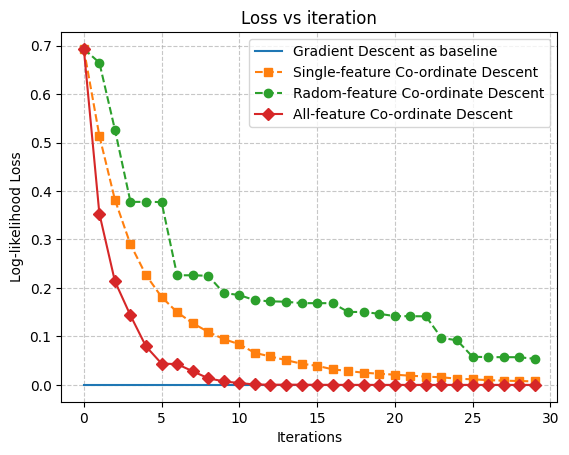

In [80]:
# Sample data
x_values = [x for x in range(num_iterations)]
loss_values = [loss_values[-1] for i in range(num_iterations)]

# Plotting the first set of values
plt.plot(x_values, loss_values, label='Gradient Descent as baseline', linestyle='-')

# Plotting the second set of values
plt.plot(x_values, l[:-1], label='Single-feature Co-ordinate Descent', marker='s', linestyle='--')

# Plotting the third set of values
plt.plot(x_values, l_random[:-1], label='Radom-feature Co-ordinate Descent', marker='o', linestyle='--')

# Plotting the first set of values
plt.plot(x_values, l_all[:-1], label='All-feature Co-ordinate Descent', marker='D', linestyle='-')

# Adding labels and title
plt.xlabel('Iterations')
plt.ylabel('Log-likelihood Loss')
plt.title('Loss vs iteration')

# Adding legend
plt.legend()

# Adding grid lines
plt.grid(True, linestyle='--', alpha=0.7)

# Display the plot
plt.show()
